In [10]:
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

In [11]:
# Function for loading notMNIST Dataset
def loadData(datafile = r"/content/sample_data/notMNIST.npz"):
    with np.load(datafile) as data:
        Data, Target = data["images"].astype(np.float32), data["labels"]
        np.random.seed(521)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data = Data[randIndx] / 255.0
        Target = Target[randIndx]
        trainData, trainTarget = Data[:10000], Target[:10000]
        validData, validTarget = Data[10000:16000], Target[10000:16000]
        testData, testTarget = Data[16000:], Target[16000:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

In [12]:
# Custom Dataset class. 
class notMNIST(Dataset):
    def __init__(self, annotations, images, transform=None, target_transform=None):
        self.img_labels = annotations
        self.imgs = images
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.imgs[idx]
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [13]:
#Define CNN
class CNN(nn.Module):
    def __init__(self, drop_out_p=0.0):
        super(CNN, self).__init__()
        #TODO
        #DEFINE YOUR LAYERS HERE
        self.conv1 = nn.Conv2d(1,32,4)
        self.batch1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,64,4)
        self.batch2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(drop_out_p)
        self.fc = nn.Linear(1024,784)
        self.fc1 = nn.Linear(784,10)

    def forward(self, x):
        #TODO
        #DEFINE YOUR FORWARD FUNCTION HERE
        out = F.relu(self.conv1(x))
        out = self.batch1(out)
        out = self.pool1(out)

        out = F.relu(self.conv2(out))
        out = self.batch2(out)
        out = self.pool2(out)

        out = torch.flatten(out, start_dim=1)
        out = self.dropout(out)
        out = F.relu(self.fc(out))
        out = self.fc1(out)
        return out

In [14]:
#Define FNN
class FNN(nn.Module):
    def __init__(self, drop_out_p=0.0):
        super(FNN, self).__init__()
        #TODO
        self.fc1 = nn.Linear(784,10)
        self.fc2 = nn.Linear(10,10)
        self.fc3 = nn.Linear(10,10)
        self.dropout = nn.Dropout(drop_out_p)
        
        #DEFINE YOUR LAYERS HERE

    def forward(self, x):
        #TODO
        out = torch.flatten(x, start_dim=1) 
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.dropout(out)
        out = self.fc3(out)
        return out

In [15]:
# Commented out IPython magic to ensure Python compatibility.
# Compute accuracy
def get_accuracy(model, dataloader):
    
    model.eval()
    device = next(model.parameters()).device
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        temp=0
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device) 
            # TODO
            # Return the accuracy
            compare = list()
            output = model(images)
            for outputs in output:
              compare.append(torch.argmax(outputs).tolist())
            compare = torch.tensor(compare)
            compare = compare.to(device)
            temp = torch.eq(labels,compare).type(torch.uint8).sum().tolist()
            total = total + temp 
        accuracy=(total/(len(dataloader)*32))*100

    return accuracy

In [16]:
def train(model, device, learning_rate, weight_decay, train_loader, val_loader, test_loader, num_epochs=50, verbose=True):
  #TODO
  # Define your cross entropy loss function here 
  # Use cross entropy loss
  criterion = nn.CrossEntropyLoss()
  
  #TODO
  # Define your optimizer here
  # Use AdamW optimizer, set the weights, learning rate and weight decay argument.
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  acc_hist = {'train':[], 'val':[], 'test': []}

  for epoch in range(num_epochs):
    model = model.train()
    ## training step
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)

        # TODO
        # Follow the step in the tutorial

        #forward
        outputs= model(images) #to get the images
        

        ## forward + backprop + loss
        loss= criterion(outputs,labels) #calculate loss
        optimizer.zero_grad()
        loss.backward()


        ## update model params
        optimizer.step()

    model.eval()
    acc_hist['train'].append(get_accuracy(model, train_loader))
    acc_hist['val'].append(get_accuracy(model, val_loader))
    acc_hist['test'].append(get_accuracy(model, test_loader))
    
    if verbose:
      print('Epoch: %d | Train Accuracy: %.2f | Validation Accuracy: %.2f | Test Accuracy: %.2f')
#%(epoch, acc_hist['train'][-1], acc_hist['val'][-1], acc_hist['test'][-1]))

  return model, acc_hist

In [17]:
def experiment(model_type='FNN', learning_rate=0.0001, dropout_rate=0.5, weight_decay=0.01, num_epochs=50, verbose=False):
  # Use GPU if it is available.
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  # Inpute Batch size:
  BATCH_SIZE = 32

  # Convert images to tensor
  transform = transforms.Compose(
      [transforms.ToTensor()])

  # Get train, validation and test data loader.
  trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()

  train_data = notMNIST(trainTarget, trainData, transform=transform)
  val_data = notMNIST(validTarget, validData, transform=transform)
  test_data = notMNIST(testTarget, testData, transform=transform)


  train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

  # Specify which model to use
  if model_type == 'CNN':
    model = CNN(dropout_rate)
  elif model_type == 'FNN':
    model = FNN(dropout_rate)

  
  # Loading model into device
  model = model.to(device)
  criterion = nn.CrossEntropyLoss()
  model, acc_hist = train(model, device, learning_rate, weight_decay, train_loader, val_loader, test_loader, num_epochs=num_epochs, verbose=verbose)
  
  # Release the model from the GPU (else the memory wont hold up)
  model.cpu()

  return model, acc_hist

In [18]:
experiment(model_type='FNN', learning_rate=0.0001, dropout_rate=0.5, weight_decay=0.01, num_epochs=50, verbose=False)

(FNN(
   (fc1): Linear(in_features=784, out_features=10, bias=True)
   (fc2): Linear(in_features=10, out_features=10, bias=True)
   (fc3): Linear(in_features=10, out_features=10, bias=True)
   (dropout): Dropout(p=0.5, inplace=False)
 ),
 {'train': [34.81429712460064,
   54.043530351437695,
   65.66493610223642,
   70.89656549520767,
   75.21964856230032,
   78.16493610223642,
   79.7823482428115,
   80.92052715654951,
   82.06869009584665,
   83.2867412140575,
   83.11701277955271,
   83.96565495207668,
   83.74600638977637,
   84.08546325878594,
   85.02396166134186,
   84.77436102236422,
   85.13378594249201,
   85.43330670926518,
   85.76277955271566,
   85.57308306709265,
   86.0423322683706,
   86.16214057507987,
   85.89257188498402,
   86.13218849840256,
   86.12220447284345,
   86.26198083067092,
   86.26198083067092,
   86.31190095846645,
   86.32188498402556,
   86.53154952076677,
   86.46166134185303,
   86.73123003194888,
   86.68130990415335,
   86.70127795527156,
   86.7

In [28]:
def compare_arch():
  model, acc_hist = experiment(model_type='FNN', learning_rate=0.0001, dropout_rate=0.0, weight_decay=0.0, num_epochs=50, verbose=False)
  plt.figure(figsize=(10,5))
  plt.title("Experiment 1: FNN Training and Test History")
  plt.plot(acc_hist['test'],label="test")
  plt.plot(acc_hist['train'],label="train")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

  model, acc_hist = experiment(model_type='CNN', learning_rate=0.0001, dropout_rate=0.0, weight_decay=0.0, num_epochs=50, verbose=False)
  plt.figure(figsize=(10,5))
  plt.title("Experiment 1: CNN Training and Test History")
  plt.plot(acc_hist['test'],label="test")
  plt.plot(acc_hist['train'],label="train")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

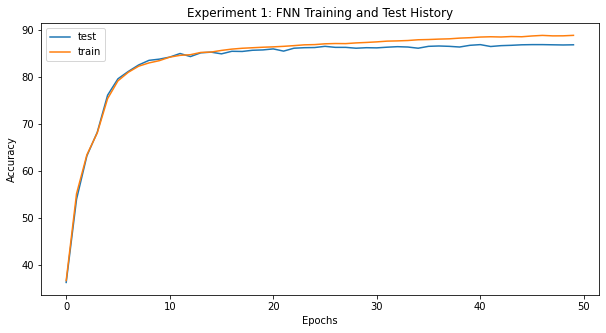

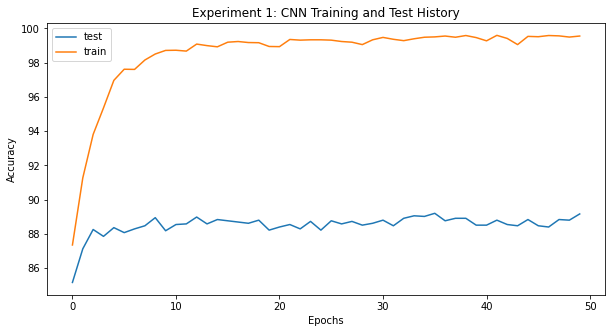

In [29]:
compare_arch()

In [31]:
def compare_dropout():
  model, acc_hist = experiment(model_type='CNN', learning_rate=0.0001, dropout_rate=0.5, weight_decay=0.0, num_epochs=50, verbose=False)
  plt.figure(figsize=(10,5))
  plt.title("Experiment 2: Dropout=0.5")
  plt.plot(acc_hist['test'],label="test")
  plt.plot(acc_hist['train'],label="train")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

  model, acc_hist = experiment(model_type='CNN', learning_rate=0.0001, dropout_rate=0.8, weight_decay=0.0, num_epochs=50, verbose=False)
  plt.figure(figsize=(10,5))
  plt.title("Experiment 2: Dropout=0.8")
  plt.plot(acc_hist['test'],label="test")
  plt.plot(acc_hist['train'],label="train")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

  model, acc_hist = experiment(model_type='CNN', learning_rate=0.0001, dropout_rate=0.95, weight_decay=0.0, num_epochs=50, verbose=False)
  plt.figure(figsize=(10,5))
  plt.title("Experiment 2: Dropout=0.95")
  plt.plot(acc_hist['test'],label="test")
  plt.plot(acc_hist['train'],label="train")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

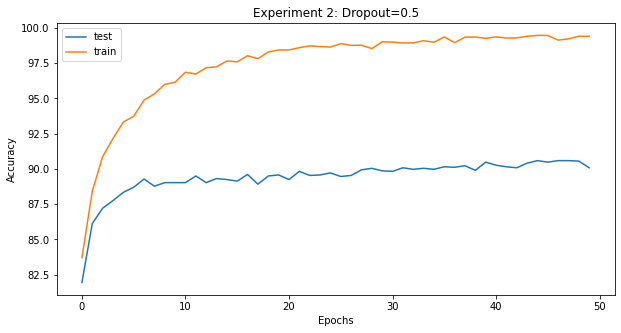

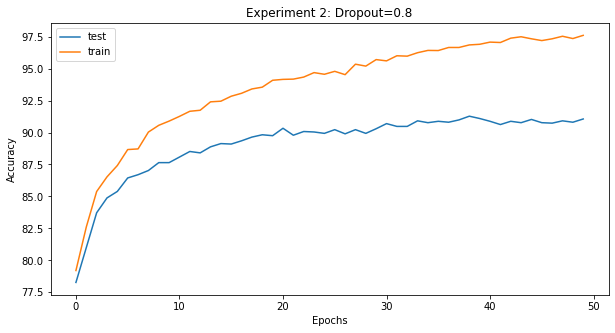

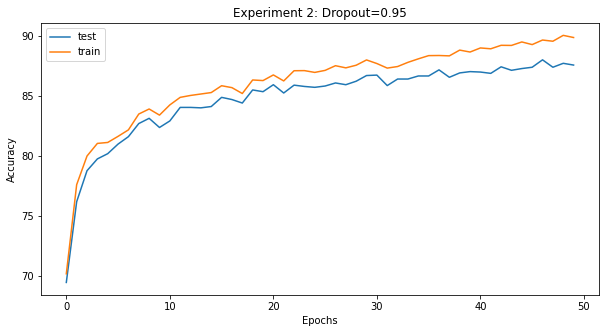

In [32]:
compare_dropout()

In [33]:
def compare_l2():
  model, acc_hist = experiment(model_type='CNN', learning_rate=0.0001, dropout_rate=0.0, weight_decay=0.1, num_epochs=50, verbose=False)
  plt.figure(figsize=(10,5))
  plt.title("Experiment 3: Weight Decay=0.1")
  plt.plot(acc_hist['test'],label="test")
  plt.plot(acc_hist['train'],label="train")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

  model, acc_hist = experiment(model_type='CNN', learning_rate=0.0001, dropout_rate=0.0, weight_decay=1.0, num_epochs=50, verbose=False)
  plt.figure(figsize=(10,5))
  plt.title("Experiment 2: Weight Decay=1.0")
  plt.plot(acc_hist['test'],label="test")
  plt.plot(acc_hist['train'],label="train")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

  model, acc_hist = experiment(model_type='CNN', learning_rate=0.0001, dropout_rate=0.0, weight_decay=10.0, num_epochs=50, verbose=False)
  plt.figure(figsize=(10,5))
  plt.title("Experiment 2: Weight Decay=10.0")
  plt.plot(acc_hist['test'],label="test")
  plt.plot(acc_hist['train'],label="train")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

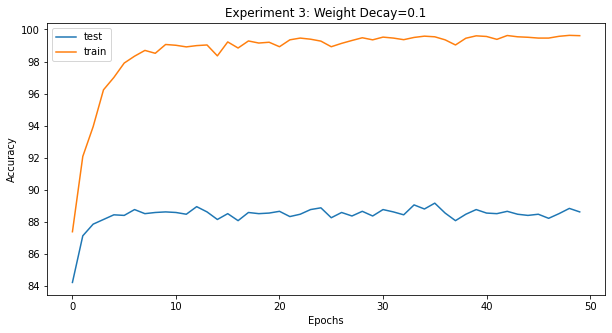

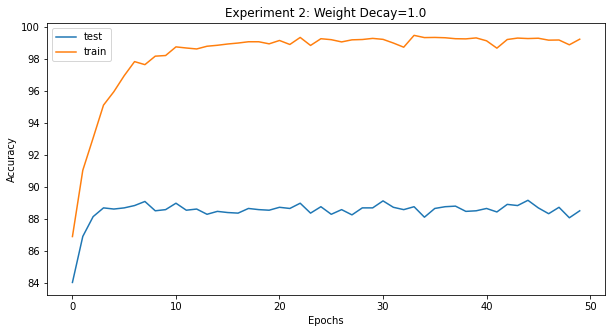

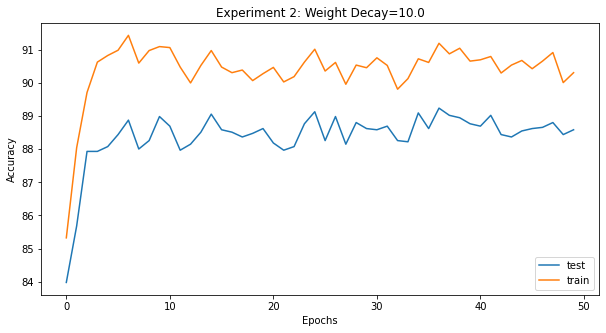

In [34]:
compare_l2()